In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import io

In [78]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name = fn, length = len(uploaded[fn])))

Saving NIFTY 50.csv to NIFTY 50.csv
User uploaded file "NIFTY 50.csv" with length 396282 bytes


In [0]:
nifty = pd.read_csv("NIFTY 50.csv")

In [145]:
nifty.tail()

,Date,Open,High,Low,Close,Volume,Turnover,P/E,P/B,Div Yield
5064,5/14/2020,9213.95,9281.10,9119.75,9142.75,602600.0,3.074350e+11,21.28,2.64,1.64
5065,5/15/2020,9182.40,9182.40,9050.00,9136.85,575900.0,3.074350e+11,21.28,2.64,1.64
5066,5/18/2020,9158.30,9158.30,8806.75,8823.25,773000.0,3.074350e+11,21.28,2.64,1.64
5067,5/19/2020,8961.70,9030.35,8855.30,8879.10,762200.0,3.074350e+11,21.28,2.64,1.64
5068,5/20/2020,8889.15,9000.05,8875.35,8965.05,NaN,3.074350e+11,21.28,2.64,1.64


In [81]:
print(nifty.shape)

(5069, 10)


In [82]:
nifty.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Volume       1
Turnover     0
P/E          0
P/B          0
Div Yield    0
dtype: int64

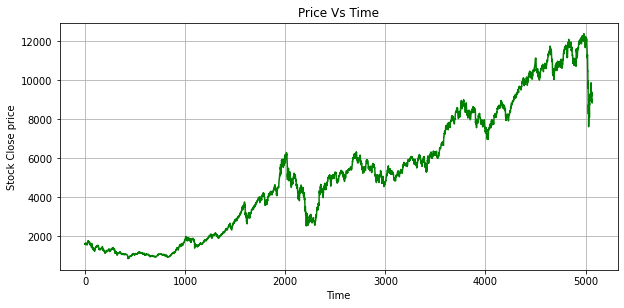

In [146]:
f, axs = plt.subplots(1, 1, figsize = (10, 10))
close_price = nifty["Close"]
plt.subplot(212)
plt.grid(True)

plt.xlabel('Time')
plt.ylabel("Stock Close price")
plt.title('Price Vs Time')

plt.plot(close_price , 'g')

In [0]:
company_close = nifty.Close.values.astype('float32')
company_close = company_close.reshape(-1, 1)
closing_stock = company_close

In [149]:
closing_stock[: , 0]

array([1592.2 , 1638.7 , 1595.8 , ..., 8823.25, 8879.1 , 8965.05],
      dtype=float32)

In [150]:
stocks = closing_stock[: , 0]
print(stocks)
stocks = stocks.reshape(len(stocks) , 1)

[1592.2  1638.7  1595.8  ... 8823.25 8879.1  8965.05]


In [0]:
#Feature scaling the vector for better model performance.

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
stocks = scaler.fit_transform(stocks)

In [0]:
train = int(len(stocks) * 0.80)
test = len(stocks) - train

In [89]:
print(train , test)

4055 1014


In [153]:
train = stocks[0:train]
print(train)

[[0.06412873]
 [0.06816938]
 [0.06444157]
 ...
 [0.5874254 ]
 [0.58152527]
 [0.5822856 ]]


In [0]:
test = stocks[len(train) : ]

In [0]:
train = train.reshape(len(train) , 1)
test = test.reshape(len(test) , 1)

In [93]:
print(train.shape , test.shape)

(4055, 1) (1014, 1)


In [0]:
#process_data for the required input for LSTM.

In [0]:
def process_data(data , n_features):
    dataX, dataY = [], []
    for i in range(len(data)-n_features-1):
        a = data[i:(i+n_features), 0]
        dataX.append(a)
        dataY.append(data[i + n_features, 0])
    return np.array(dataX), np.array(dataY)

In [0]:
#Here I am taking 2 past values to predict a single value. This has already been checked and optimized after taking several cases.

n_features = 2

trainX, trainY = process_data(train, n_features)
testX, testY = process_data(test, n_features)

In [96]:
print(trainX.shape , trainY.shape , testX.shape , testY.shape)

(4052, 2) (4052,) (1011, 2) (1011,)


In [0]:
#Reshaping again for required LSTM input as (sample , timestamp , features per sample).

#Here I am taking timestamp as 1.

trainX = trainX.reshape(trainX.shape[0] , 1 ,trainX.shape[1])
testX = testX.reshape(testX.shape[0] , 1 ,testX.shape[1])

In [0]:
import math
from keras.models import Sequential
from keras.layers import Dense , BatchNormalization , Dropout , Activation
from keras.layers import LSTM , GRU
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.optimizers import Adam , SGD , RMSprop

In [161]:
#Checkpointing the model when required and using other callbacks.

filepath="stock_weights.hdf5"
from keras.callbacks import ReduceLROnPlateau , ModelCheckpoint
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.1, epsilon=0.0001, patience=1, verbose=1)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='max')

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [162]:
#The learning rate has been tuned for several times and so is the batch_size and the neurons
# Build Model

model = Sequential()
model.add(GRU(256 , input_shape = (1 , n_features) , return_sequences = True))
model.add(Dropout(0.4))
model.add(LSTM(256))
model.add(Dropout(0.4))
model.add(Dense(64 ,  activation = 'relu'))
model.add(Dense(1))

print(model.summary())


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_4 (GRU)                  (None, 1, 256)            198912    
_________________________________________________________________
dropout_7 (Dropout)          (None, 1, 256)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 740,737
Trainable params: 740,737
Non-trainable params: 0
________________________________________________

In [0]:
# Compile Model

model.compile(loss = 'mean_squared_error', optimizer = Adam(lr = 0.0005), metrics = ['mean_squared_error'])


In [164]:
# Run Model

history = model.fit(trainX, trainY, epochs = 100 , batch_size = 32, 
          callbacks = [checkpoint , lr_reduce] , validation_data = (testX, testY))


Train on 4052 samples, validate on 1011 samples
Epoch 1/100
4052/4052 [==============================] - 3s 849us/step - loss: 0.0131 - mean_squared_error: 0.0131 - val_loss: 6.4433e-04 - val_mean_squared_error: 6.4433e-04

Epoch 00001: val_loss improved from -inf to 0.00064, saving model to stock_weights.hdf5
Epoch 2/100
4052/4052 [==============================] - 3s 631us/step - loss: 7.8290e-04 - mean_squared_error: 7.8290e-04 - val_loss: 1.4922e-04 - val_mean_squared_error: 1.4922e-04

Epoch 00002: val_loss did not improve from 0.00064
Epoch 3/100
4052/4052 [==============================] - 3s 630us/step - loss: 5.9612e-04 - mean_squared_error: 5.9612e-04 - val_loss: 1.7363e-04 - val_mean_squared_error: 1.7363e-04

Epoch 00003: val_loss did not improve from 0.00064

Epoch 00003: ReduceLROnPlateau reducing learning rate to 5.0000002374872565e-05.
Epoch 4/100
4052/4052 [==============================] - 3s 635us/step - loss: 5.6331e-04 - mean_squared_error: 5.6331e-04 - val_loss: 1

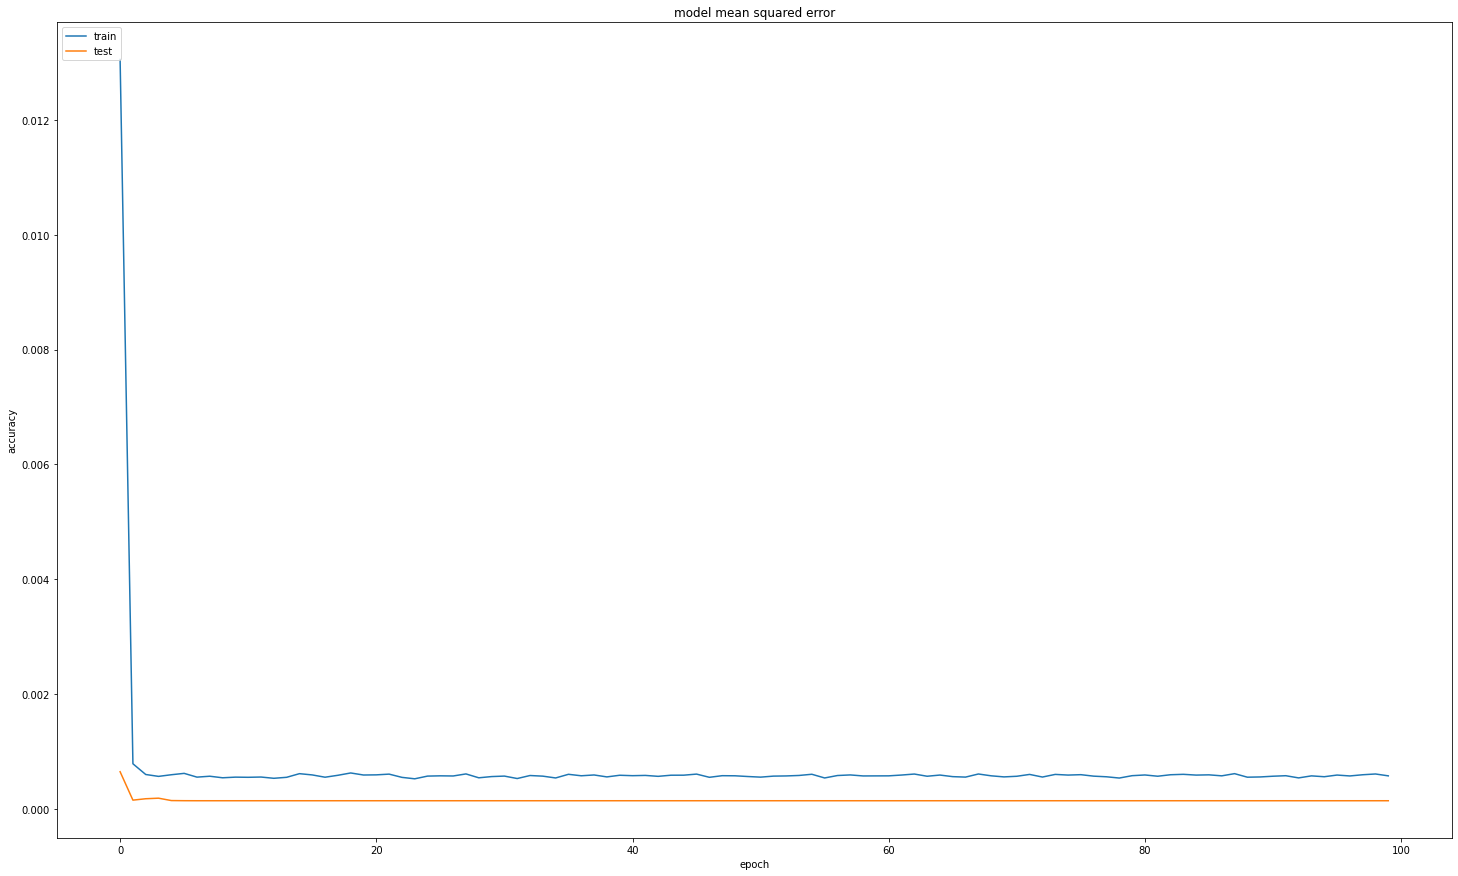

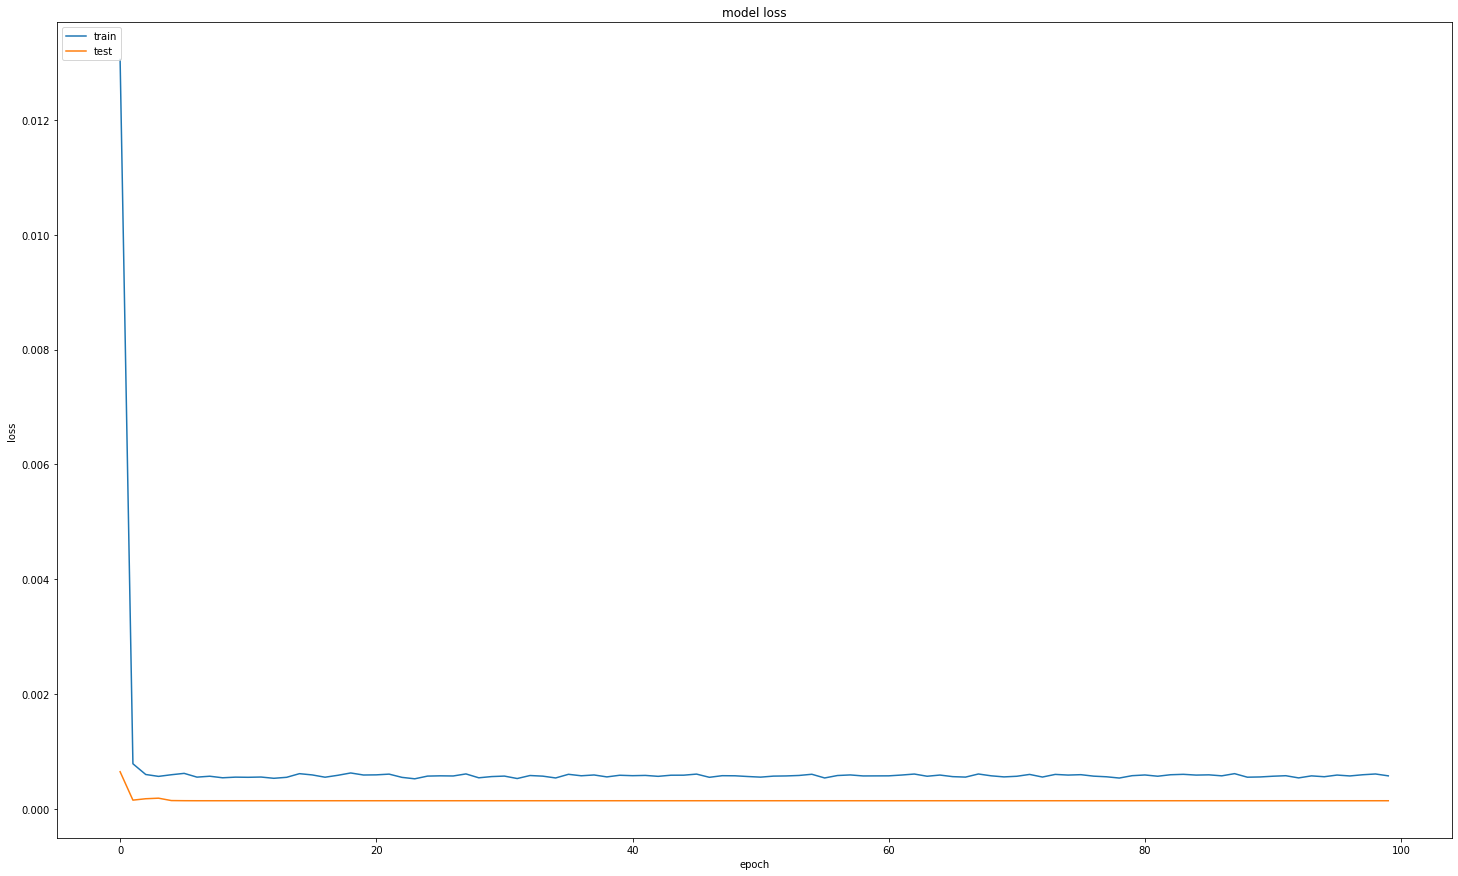

In [165]:
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('model mean squared error')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [166]:
# The mean square error for validation set is 0.000138 which is very low and good as well.

def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))
    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]

model_score(model, trainX, trainY , testX, testY)

Train Score: 0.00005 MSE (0.01 RMSE)
Test Score: 0.00014 MSE (0.01 RMSE)


(4.7945501886076395e-05, 0.00013886819813312072)

In [167]:
# Inverse transforming the scaled vector earlier and checking for the error visually in the graph

pred = model.predict(testX)
pred = scaler.inverse_transform(pred)
pred[:10]

array([[7634.9854],
       [7722.076 ],
       [7826.525 ],
       [7860.054 ],
       [7858.792 ],
       [7851.2983],
       [7823.5327],
       [7851.8057],
       [7916.155 ],
       [7861.8403]], dtype=float32)

In [168]:
testY = testY.reshape(testY.shape[0] , 1)
testY = scaler.inverse_transform(testY)
testY[:10]

array([[7850.45  ],
       [7914.7   ],
       [7914.75  ],
       [7912.0493],
       [7899.3003],
       [7855.05  ],
       [7962.65  ],
       [7979.8994],
       [7847.25  ],
       [7849.7993]], dtype=float32)

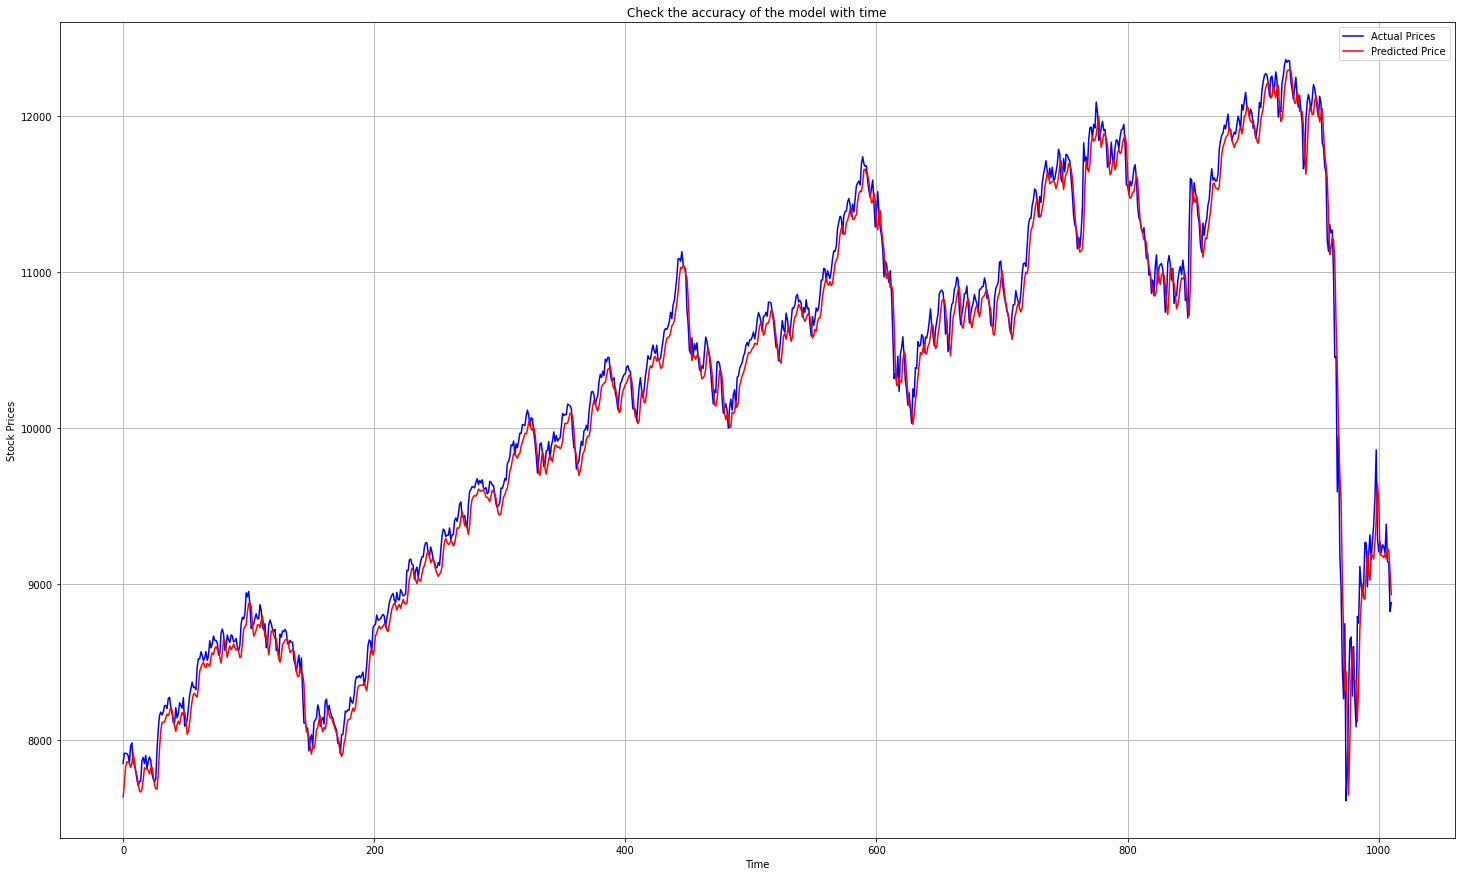

In [169]:
# The space between the predicted (red) and actual (blue) line is self explanatory for the model tuning and performance.

plt.rcParams["figure.figsize"] = (25,15)
plt.plot(testY , 'b', label = 'Actual Prices')
plt.plot(pred , 'r', label = 'Predicted Price')
plt.xlabel('Time')
plt.ylabel('Stock Prices')
plt.title('Check the accuracy of the model with time')
plt.legend()
plt.grid(True)
plt.show()

In [170]:
testY

array([[7850.45],
       [7914.7 ],
       [7914.75],
       ...,
       [9136.85],
       [8823.25],
       [8879.1 ]], dtype=float32)

In [171]:
pred

array([[7634.9854],
       [7722.076 ],
       [7826.525 ],
       ...,
       [9212.834 ],
       [9084.359 ],
       [8931.449 ]], dtype=float32)